In [38]:
# Import Libraries 
# -----------------
import numpy as np
import matplotlib.pyplot as plt

# Show Plot in The Notebook
# -------------------------
plt.switch_backend("nbagg") 
from matplotlib import gridspec

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

plt.style.use(['science', 'notebook', 'grid'])
from scipy import special

# Set up the constants and discretization

In [39]:
# Define constant
# ----------------------

# diffusion coefficient
D = 1e-5 # cm2/s
# number of electron
n = 1
# Faraday's cte
F = 94485 # C/mol
# Ideal gas constant
R = 8.314 # J/K.mol
# initial concentration 
ci = 1e-6 # mol/cm3
# surface area
A = 1 # cm2

# discretize
# ----------------------

# model diffusion coefficient 
Dm = 0.4 # Dm should be less than 0.5 to not blow up the simulation (CFL condition)
print(f'Model diffusion coefficient Dm: {Dm}')

# time discretization 
# total simulation time
print('-------------')
print('TIME DISCRETIZATION')

tmax = 60*3 # s
# number of time iteration
nt = 1000
# time step
dt = round(tmax / (nt - 1),4) # s

print(f'total simulation time: {tmax} (s)')
print(f'total time iteration: {nt}')
print(f'time step: {dt} (s)')


# space discretization
print('-------------')
print('SPACE DISCRETIZATION')

# space step
dx = np.sqrt(D*dt/Dm) # cm 
# space domain
xmax = 10 * np.sqrt(2*D*tmax) # cm
# space iteration
nx = round(xmax/dx) + 1

print(f'space step: {round(dx,4)} (cm)')
print(f'space domain: {round(xmax,4)} (cm)')
print(f'space iteration: {nx}')

Model diffusion coefficient Dm: 0.4
-------------
TIME DISCRETIZATION
total simulation time: 180 (s)
total time iteration: 1000
time step: 0.1802 (s)
-------------
SPACE DISCRETIZATION
space step: 0.0021 (cm)
space domain: 0.6 (cm)
space iteration: 284


<IPython.core.display.Javascript object>


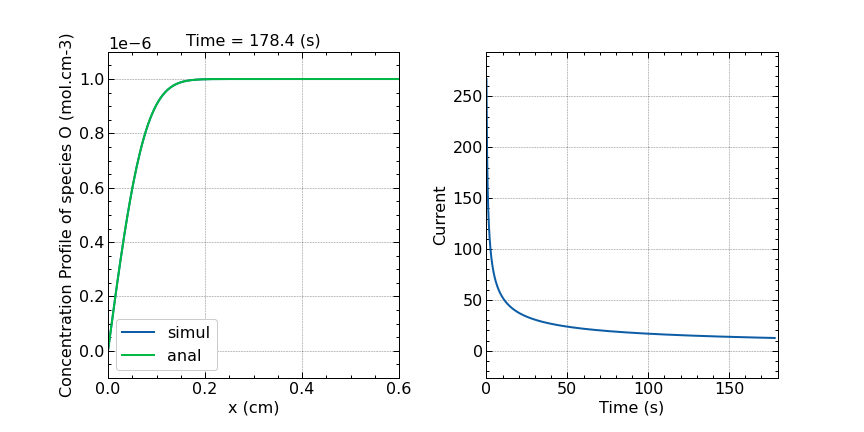

In [40]:
# concentration array
c = np.zeros(nx) # now
c = c + ci # at t = 0, uniform concentration

cnew = np.zeros(nx) # new
d2cx = np.zeros(nx) # 2nd space derivative of c


# anal c
c_anal = np.zeros(nx) + ci

# initiate coordinate
x = np.arange(nx)
x = x * dx
t = np.arange(nt)
t = t * dt

# current array 
current_array = np.zeros(nt)

# Plot position configuration
# ---------------------------
plt.ion()
fig = plt.figure(figsize=(12, 6))
gs  = gridspec.GridSpec(1,2,width_ratios=[1,1],height_ratios=None,hspace=0.3, wspace=0.3)


# plot concentration
ax1 = plt.subplot(gs[0])
concentration, = ax1.plot(x,c, label = 'simul')
concentrationanal, = ax1.plot(x,c_anal, label = 'anal')
ax1.set_xlim(0,xmax) 
ax1.set_ylim(-np.max(c), np.max(c))
ax1.legend()
ax1.set_title('Time t = 0 (s)')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('Concentration Profile of species O (mol.cm-3)')

# plot current
ax2 = plt.subplot(gs[1])
current_line, = ax2.plot(t, current_array)
ax2.set_xlim(0,tmax)
ax2.set_ylim(-np.max(current_array), np.max(current_array))
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current')

plt.show()


# Simulation 

In [41]:
# simulate
idisp = 10
# loop over time
for it in range(nt):
    
    # boundary conditions
    c[0] = 0 # concentration at x = 0 -> 0 instantaneous
    c[-1] = ci # concentration at far away rest unchanged
    
    # 2nd derivative in space 
    for i in range(1,nx-1):
        d2cx[i] = (c[i+1] - 2*c[i] + c[i-1]) / dx ** 2
        
    # time extrapolation
    cnew = c + D * dt * d2cx
    
    J = - D * (cnew[1] - cnew[0]) / dx
    current = - n * F * A * J
    
    current_array[it] = current*10**6
    # remap time levels
    c = cnew 
    
    time = t[it]
    
    c_anal = ci * special.erf(x/(2*np.sqrt(D*time)))
    if (it % idisp) == 0:
        
        ax1.set_title(f'Time = {round(time,2)} (s)')
        ax1.set_ylim(-0.1*np.max(abs(c)), 1.1*np.max(abs(c)))
        concentration.set_ydata(c)
        concentrationanal.set_ydata(c_anal)
        ax2.set_ylim(-0.1*np.max(abs(current_array)), 1.1*np.max(abs(current_array)))
        current_line.set_xdata(t[:it])
        current_line.set_ydata(current_array[:it])
        plt.gcf().canvas.draw()

In [42]:
# cottrel analytical solution
def cottrel_analytic(t):
    i = ( n * F * A * (D ** 0.5) * ci ) / (np.pi**0.5 * np.sqrt(t))
    return i
    
cottrel_current = cottrel_analytic(t)  * 10 ** 6 # uA

<IPython.core.display.Javascript object>


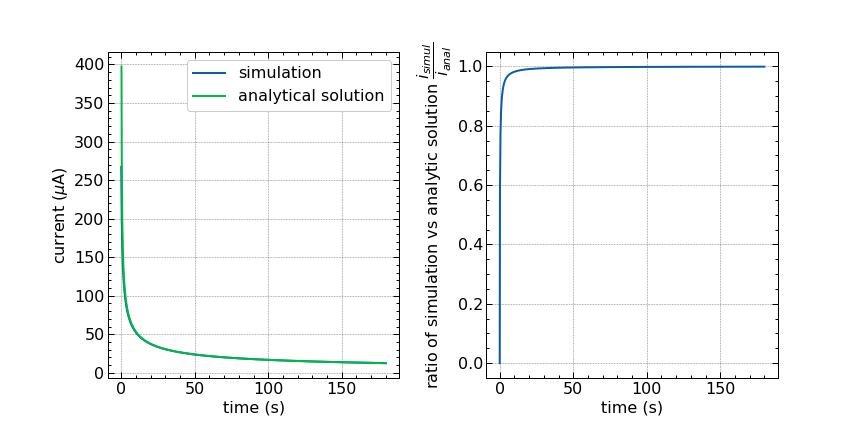

Text(0, 0.5, 'ratio of simulation vs analytic solution $\\dfrac{i_{simul}}{i_{anal}}$')

In [43]:
plt.ion()
fig2 = plt.figure(figsize = (12,6))
gs2  = gridspec.GridSpec(1,2,width_ratios=[1,1],height_ratios=None,hspace=0.3, wspace=0.3)

ax3 = plt.subplot(gs2[0])
ax3.plot(t, current_array, label = 'simulation')
ax3.plot(t, cottrel_current, label = 'analytical solution')
ax3.set_xlabel('time (s)')
ax3.set_ylabel(r'current ($\mu$A)')
ax3.legend()

ax4 = plt.subplot(gs2[1])
ax4.plot(t, current_array/cottrel_current)
ax4.set_xlabel('time (s)')
ax4.set_ylabel(r'ratio of simulation vs analytic solution $\dfrac{i_{simul}}{i_{anal}}$')
